In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
import tensorflow as tf
from tensorflow.keras import layers, models, Input, Model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt

# Laden der Metadaten
metadata = pd.read_csv("HAM10000_metadata.csv")
print(metadata.head())


     lesion_id      image_id   dx dx_type   age   sex localization
0  HAM_0000118  ISIC_0027419  bkl   histo  80.0  male        scalp
1  HAM_0000118  ISIC_0025030  bkl   histo  80.0  male        scalp
2  HAM_0002730  ISIC_0026769  bkl   histo  80.0  male        scalp
3  HAM_0002730  ISIC_0025661  bkl   histo  80.0  male        scalp
4  HAM_0001466  ISIC_0031633  bkl   histo  75.0  male          ear


In [2]:
missing_values = metadata.isnull().sum()

missing_percentage = (missing_values / len(metadata)) * 100


In [3]:
missing_summary = pd.DataFrame({
    'Missing Values': missing_values,
    'Percentage': missing_percentage
})


In [4]:
missing_summary = missing_summary[missing_summary['Missing Values'] > 0]

print("Missing values in dataset:")
print(missing_summary)

Missing values in dataset:
     Missing Values  Percentage
age              57    0.569146


In [5]:
metadata_cleaned = metadata.dropna(subset=['age'])

In [6]:
categorical_cols = ['sex', 'localization']

In [7]:
metadata = pd.get_dummies(metadata_cleaned, columns=categorical_cols)

In [8]:
label_encoder = LabelEncoder()
metadata['label'] = label_encoder.fit_transform(metadata['dx'])

metadata.info()


<class 'pandas.core.frame.DataFrame'>
Index: 9958 entries, 0 to 10014
Data columns (total 24 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   lesion_id                     9958 non-null   object 
 1   image_id                      9958 non-null   object 
 2   dx                            9958 non-null   object 
 3   dx_type                       9958 non-null   object 
 4   age                           9958 non-null   float64
 5   sex_female                    9958 non-null   bool   
 6   sex_male                      9958 non-null   bool   
 7   sex_unknown                   9958 non-null   bool   
 8   localization_abdomen          9958 non-null   bool   
 9   localization_acral            9958 non-null   bool   
 10  localization_back             9958 non-null   bool   
 11  localization_chest            9958 non-null   bool   
 12  localization_ear              9958 non-null   bool   
 13  localiz

In [9]:
image_folder = './HAM10000_images'

IMAGE_SIZE = (124, 124)

def load_image(image_id):
    image_path = os.path.join(image_folder, image_id + '.jpg')
    try:
        image = Image.open(image_path).resize(IMAGE_SIZE)
        image = image.convert('RGB')  
        image = np.array(image)
        return image
    except:
        return None


In [10]:
metadata['image'] = metadata['image_id'].apply(load_image)


metadata = metadata[metadata['image'].notnull()]


In [11]:
X_images = np.stack(metadata['image'].values)

metadata_features = metadata.drop(['lesion_id', 'image_id', 'dx', 'dx_type', 'image', 'label'], axis=1)


In [12]:
scaler = StandardScaler()
numerical_cols = ['age']
metadata_features[numerical_cols] = scaler.fit_transform(metadata_features[numerical_cols])

X_metadata = metadata_features.values

y = tf.keras.utils.to_categorical(metadata['label'], num_classes=len(metadata['label'].unique()))


In [13]:
X_images_train, X_images_test, X_metadata_train, X_metadata_test, y_train, y_test = train_test_split(
    X_images, X_metadata, y, test_size=0.2, random_state=42
)

In [14]:
X_images_train = np.array(X_images_train)
X_images_test = np.array(X_images_test)
X_metadata_train = np.array(X_metadata_train, dtype=np.float32)
X_metadata_test = np.array(X_metadata_test, dtype=np.float32)
y_train = np.array(y_train, dtype=np.float32)
y_test = np.array(y_test, dtype=np.float32)


In [15]:
X_images_train = preprocess_input(X_images_train)
X_images_test = preprocess_input(X_images_test)

image_input = Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))


In [16]:
# load ResNet50
resnet_model = ResNet50(weights='imagenet', include_top=False, input_tensor=image_input)


In [17]:
x = resnet_model.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dropout(0.3)(x)


In [18]:
metadata_input = Input(shape=(X_metadata.shape[1],))


In [19]:
m = layers.Dense(32, activation='relu')(metadata_input)
m = layers.Dropout(0.3)(m)
m = layers.Dense(32, activation='relu')(m)


In [20]:
combined = layers.concatenate([x, m])


In [21]:
z = layers.Dense(32, activation='relu')(combined)
z = layers.Dense(y.shape[1], activation='softmax')(z)

model = Model(inputs=[image_input, metadata_input], outputs=z)


In [22]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 124, 124,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 130, 130,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 62, 62,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 62, 62,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 62, 62,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 64, 64,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 31, 31,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 31, 31,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 31, 31,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 31, 31,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 31, 31,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 31, 31,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 31, 31,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 31, 31,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 31, 31,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 31, 31,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 31, 31,    │      1,024 │ conv2_block1_3_c

 Total params: 23,723,879 (90.50 MB)

 Trainable params: 23,670,759 (90.30 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [23]:
history = model.fit(
    [X_images_train, X_metadata_train],
    y_train,
    validation_data=([X_images_test, X_metadata_test], y_test),
    epochs=5,
    batch_size=32
)

Epoch 1/5


c:\Users\tillb\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor', 'keras_tensor_178']. Received: the structure of inputs=('*', '*')
  warnings.warn(


249/249 ━━━━━━━━━━━━━━━━━━━━ 334s 1s/step - accuracy: 0.6663 - loss: 1.0373 - val_accuracy: 0.6832 - val_loss: 3.1895
Epoch 2/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 278s 1s/step - accuracy: 0.7393 - loss: 0.7443 - val_accuracy: 0.7154 - val_loss: 0.7446
Epoch 3/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 270s 1s/step - accuracy: 0.7628 - loss: 0.6657 - val_accuracy: 0.7605 - val_loss: 0.6426
Epoch 4/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 283s 1s/step - accuracy: 0.7702 - loss: 0.6449 - val_accuracy: 0.6747 - val_loss: 0.8450
Epoch 5/5
249/249 ━━━━━━━━━━━━━━━━━━━━ 263s 1s/step - accuracy: 0.7925 - loss: 0.5646 - val_accuracy: 0.7209 - val_loss: 0.8577


In [24]:
loss, accuracy = model.evaluate([X_images_test, X_metadata_test], y_test)
print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')

63/63 ━━━━━━━━━━━━━━━━━━━━ 12s 187ms/step - accuracy: 0.7251 - loss: 0.9091
Test Loss: 0.8577
Test Accuracy: 0.7209


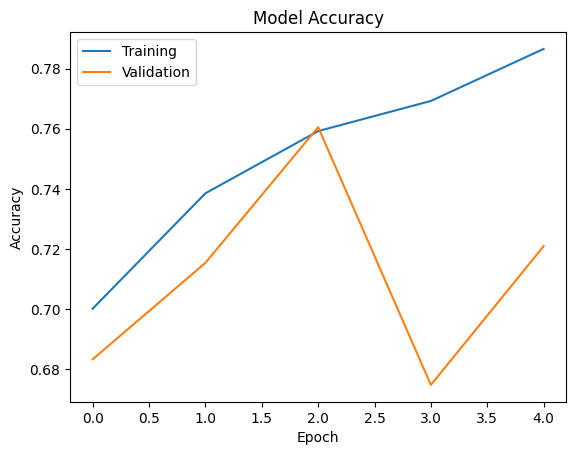

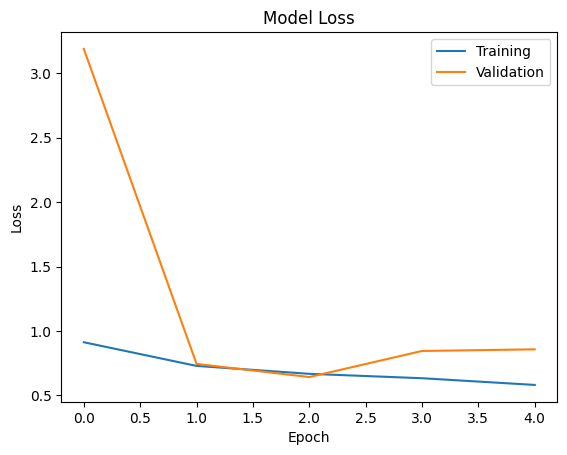

In [25]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [26]:
model.save("ResNet50.h5")